In [29]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro, pearsonr

# 한글출력
plt.rcParams['font.family'] = 'Malgun Gothic'  # 윈도우 기준
plt.rcParams['axes.unicode_minus'] = False     # 마이너스 깨짐 방지

# Set base path
BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), "../../"))
CCTV_PATH = os.path.join(BASE_DIR, "data", "processed_counts", "cctv__gu_counts.csv")
CRIME_PATH = os.path.join(BASE_DIR, "data", "processed", "crime_rate__processed.csv")

OUTPUT_DIR = os.path.join(BASE_DIR, "output")
os.makedirs(OUTPUT_DIR, exist_ok=True)

# 1. Load datasets
cctv_df = pd.read_csv(CCTV_PATH)
crime_df = pd.read_csv(CRIME_PATH)

# 2. Rename for clarity
cctv_df = cctv_df.rename(columns={"counts": "cctv_counts"})
crime_df = crime_df.rename(columns={"counts": "crime_counts"})

# 3. Merge on 'gu_code'
df = pd.merge(cctv_df, crime_df, on="gu_name", how="inner")

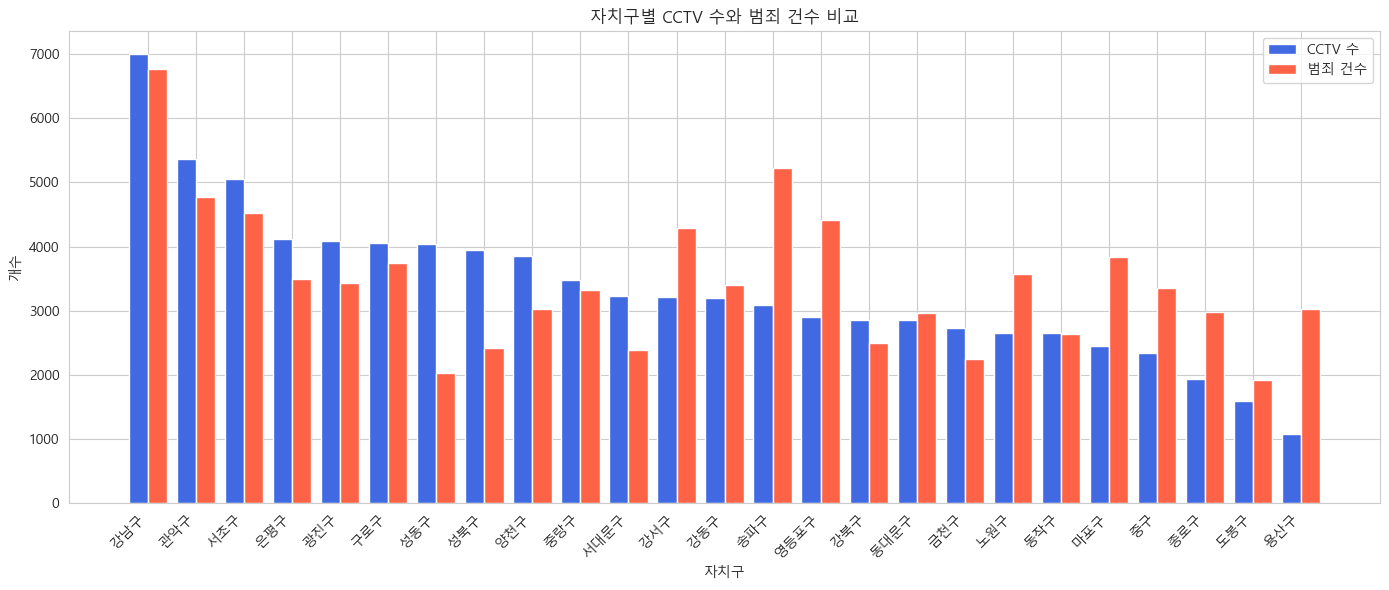

In [30]:
# 📈 시각화
plt.figure(figsize=(14, 6))
df_sorted = df.sort_values("cctv_counts", ascending=False)

bar_width = 0.4
x = range(len(df_sorted))

plt.bar(x, df_sorted["cctv_counts"], width=bar_width, label="CCTV 수", color="royalblue")
plt.bar([i + bar_width for i in x], df_sorted["crime_counts"], width=bar_width, label="범죄 건수", color="tomato")

plt.xticks([i + bar_width / 2 for i in x], df_sorted["gu_name"], rotation=45, ha='right')
plt.xlabel("자치구")
plt.ylabel("개수")
plt.title("자치구별 CCTV 수와 범죄 건수 비교")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "cctv_vs_crime_by_gu.png"), dpi=300)
plt.show()

In [31]:
# 4. Shapiro-Wilk normality test
print("🔍 Shapiro-Wilk Test for Normality:")
stat_cctv, p_cctv = shapiro(df["cctv_counts"])
stat_crime, p_crime = shapiro(df["crime_counts"])
print(f"CCTV counts: p-value = {p_cctv:.4f}")
print(f"Crime counts: p-value = {p_crime:.4f}")

if p_cctv > 0.05 and p_crime > 0.05:
    print("\n✅ Both variables are normally distributed. Proceeding with Pearson correlation.")
    r, p_value = pearsonr(df["cctv_counts"], df["crime_counts"])
    print(f"📈 Pearson correlation coefficient: r = {r:.4f}")
    print(f"📉 p-value = {p_value:.4}")
else:
    print("\n⚠️ At least one variable is not normally distributed. Pearson correlation not recommended.")

🔍 Shapiro-Wilk Test for Normality:
CCTV counts: p-value = 0.1491
Crime counts: p-value = 0.0637

✅ Both variables are normally distributed. Proceeding with Pearson correlation.
📈 Pearson correlation coefficient: r = 0.6088
📉 p-value = 0.001239


## ✅ 정규성 검정 결과
CCTV counts p = 0.1491

Crime counts p = 0.0637

두 p-value 모두 0.05보다 크므로, 정규성을 만족한다고 판단할 수 있습니다. 따라서 피어슨 상관계수 적용은 통계적으로 타당합니다.

## 📈 피어슨 상관계수 결과
r = 0.6088: 양의 중간~강한 상관관계 (moderate to strong positive correlation)

p-value = 0.0012 (≈ 1.24e-03): 유의수준 0.05보다 훨씬 작음 → 통계적으로 유의한 상관관계

## 📌 해석 요약
서울시 자치구 단위에서 CCTV 개수와 범죄 발생 건수 간에는 유의미한 양의 상관관계가 존재합니다.

즉, CCTV가 많이 설치된 구일수록 범죄 발생 건수도 높은 경향이 있습니다.

이는 CCTV가 많아서 범죄가 많은 것이라기보다는, 범죄 발생이 잦은 지역에 CCTV를 많이 설치한 결과일 가능성이 큽니다.

따라서, CCTV 개수는 범죄율을 고려한 인프라 대응 수단으로 해석하는 것이 타당합니다.

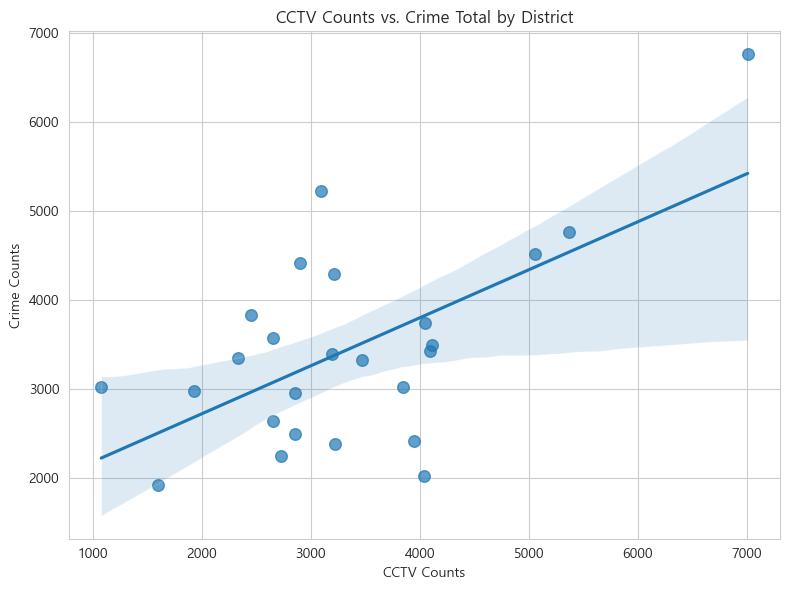

In [32]:
# 5. Visualization
plt.figure(figsize=(8, 6))
sns.regplot(data=df, x="cctv_counts", y="crime_counts", ci=95, scatter_kws={"s": 70, "alpha": 0.7})
plt.title("CCTV Counts vs. Crime Total by District")
plt.xlabel("CCTV Counts")
plt.ylabel("Crime Counts")
plt.tight_layout()
plt.grid(True)
plt.savefig(os.path.join(OUTPUT_DIR, "pearson_scatter.png"), dpi=300)
plt.show()

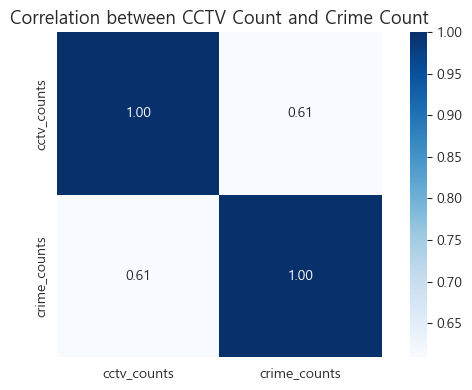

In [33]:
# 상관행렬 계산
corr = df[["cctv_counts", "crime_counts"]].corr(method="pearson")

# 시각화
plt.figure(figsize=(6, 4))
sns.heatmap(corr, annot=True, cmap="Blues", fmt=".2f", cbar=True, square=True)
plt.title("Correlation between CCTV Count and Crime Count", fontsize=13)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "correlation_matrix.png"), dpi=300)
plt.show()